# <span style="color:#0073e6">0. 사례준비</span>
<style>
@media print
{
h1 {page-break-before:always}
}
</style>

> **Libaray & Environment Settings** 

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
#plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)
np.random.seed(123)
%matplotlib inline

import time

> **MNIST DATA SET LOADING**

In [2]:
import gzip
f = gzip.open('/content/mnist.pkl.gz', 'rb')
train_set, validation_set, t = pickle.load(f, encoding='latin1')
f.close()

x, y = t[0], t[1]
del t
print(x.shape)
print(y.shape)

(10000, 784)
(10000,)


# <span style="color:#0073e6">1. 대표적인 군집화 성능 평가지표<span>
### 1.1. 사전에 정의된 그룹이 있는 경우

In [3]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import silhouette_score
c = [0,0,0,1,1,1]
t = [1,1,1,2,2,2]
print(homogeneity_score(t,c))
print(completeness_score(t,c))
print(v_measure_score(t,c))

1.0
1.0
1.0


### 1.2. Silhouette Coefficient


In [4]:
#from sklearn.metrics import silhouette_score
#silhouette_score(x, labels, metric='euclidean')

# <span style="color:#0073e6">2. Partitioning methods<span>
### 2.1. K-means

In [5]:
#from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=10)
kmeans.fit(x)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=10)

> **클러스터링 성능**
>> 사전 정의 군집 재현 정도


In [6]:
pred = kmeans.predict(x)
print(' homogeneity: %.4f' % homogeneity_score(y,pred))
print('completeness: %.4f' % completeness_score(y,pred))
print('   v-measure: %.4f' % v_measure_score(y,pred))

 homogeneity: 0.5114
completeness: 0.5193
   v-measure: 0.5153


>> Silhouette Coefficient

In [7]:
print('Silhouette Coefficient : %.4f' % silhouette_score(x, pred))

Silhouette Coefficient : 0.0719


> **차원축소기법을 사용한 클러스터링 성능 개선**

In [8]:
from sklearn.decomposition import IncrementalPCA
pca = IncrementalPCA(n_components=784)
pca.fit(x)
pca_x = pca.transform(x)

kmeans = MiniBatchKMeans(n_clusters=10)
kmeans.fit(pca_x)
pred = kmeans.predict(pca_x)
print(v_measure_score(y,pred), silhouette_score(x, pred))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.4802926744915407 0.0638658


> **군집개수(k)의 결정**

In [9]:
results = []
for k in range(2, 51):
    kmeans = MiniBatchKMeans(n_clusters=k)
    kmeans.fit(pca_x)
    pred = kmeans.predict(pca_x)
    results.append([kmeans.inertia_, v_measure_score(y,pred), silhouette_score(x, pred)])
results = pd.DataFrame(results).reset_index()
results.columns = ['k','Inertia','V-measure','Silhouette']
results['k'] += 2
results.head()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: Futur

,k,Inertia,V-measure,Silhouette
0,2,495463.347488,0.249892,0.053901
1,3,470362.144749,0.224690,0.056323
2,4,451553.498564,0.326692,0.053802
3,5,436942.757424,0.358526,0.062668
4,6,421281.823889,0.414453,0.052785


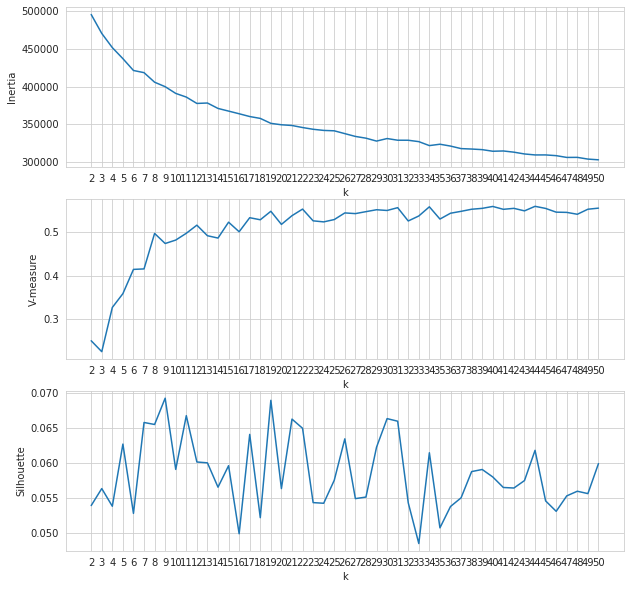

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
sns.lineplot(x='k', y='Inertia', data=results, ax=ax[0])
ax[0].set_xticks(results['k'])
sns.lineplot(x='k', y='V-measure', data=results, ax=ax[1])
ax[1].set_xticks(results['k'])
sns.lineplot(x='k', y='Silhouette', data=results, ax=ax[2])
ax[2].set_xticks(results['k']);

> **군집화 모델링 함수화**

In [11]:
def cluster_scores(model, x, y):
    start_time = time.time()
    model.fit(x)
    pred = model.predict(x)
    end_time = time.time() - start_time
    v = v_measure_score(y, pred)
    s = silhouette_score(x, pred)
    return v, s, end_time

In [12]:
results = pd.DataFrame(columns=['v_measure', 'silhouette','time'])
k = 12
kmeans = MiniBatchKMeans(n_clusters=k)
scores = cluster_scores(kmeans, pca_x, y)
results.loc['kmeans'] = scores
results

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,v_measure,silhouette,time
kmeans,0.458016,0.056967,0.656106


### 2.2. Mean Shift

In [13]:
from sklearn.cluster import MeanShift
MS = MeanShift(bandwidth=2, n_jobs=-1)
scores = cluster_scores(MS, pca_x, y)
results.loc['MeanShift'] = scores
results

,v_measure,silhouette,time
kmeans,0.458016,0.056967,0.656106
MeanShift,0.404710,0.002412,442.926717


> **도출된 군집 개수 확인**

In [14]:
MS.cluster_centers_.shape[0]

9473

# <span style="color:#0073e6">3. Hierarchical Methods<span>
### 3.1. AgglomerativeClustering

In [15]:
def cluster_scores2(model, x, y):
    start_time = time.time()
    pred = model.fit_predict(x)
    end_time = time.time() - start_time
    v = v_measure_score(y, pred)
    s = silhouette_score(x, pred)
    return v, s, end_time

In [16]:
from sklearn.cluster import AgglomerativeClustering
AC = AgglomerativeClustering(n_clusters=10)
scores = cluster_scores2(AC, pca_x, y)
results.loc['AGNES'] = scores
results

,v_measure,silhouette,time
kmeans,0.458016,0.056967,0.656106
MeanShift,0.404710,0.002412,442.926717
AGNES,0.711440,0.038524,36.474978


> **덴드로그램 시각화 함수**

In [17]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    return dendrogram(linkage_matrix, **kwargs)

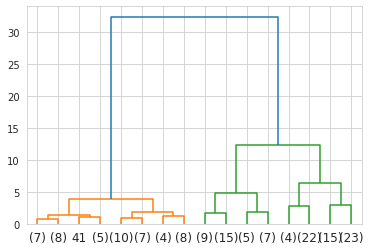

In [18]:
from sklearn.datasets import load_iris
iris = load_iris()
iris = iris.data
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(iris)

plot_dendrogram(model, truncate_mode = 'level', p=3);

### 3.2. BIRCH

In [19]:
from sklearn.cluster import Birch
BIRCH = Birch(n_clusters=10)
scores = cluster_scores(BIRCH, pca_x, y)
results.loc['Birch'] = scores
results

,v_measure,silhouette,time
kmeans,0.458016,0.056967,0.656106
MeanShift,0.404710,0.002412,442.926717
AGNES,0.711440,0.038524,36.474978
Birch,0.711440,0.038524,51.653268


# <span style="color:#0073e6">4. Density-based Methods<span>
### 4.1. DBSCAN

In [20]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=2)
scores = cluster_scores2(dbscan, pca_x, y)
results.loc['DBSCAN'] = scores
results

,v_measure,silhouette,time
kmeans,0.458016,0.056967,0.656106
MeanShift,0.404710,0.002412,442.926717
AGNES,0.711440,0.038524,36.474978
Birch,0.711440,0.038524,51.653268
DBSCAN,0.061929,-0.140310,7.870634


> **군집 개수 확인**

In [21]:
dbscan.core_sample_indices_.shape

(182,)

### 4.2. OPTICS

In [22]:
from sklearn.cluster import OPTICS
optics = OPTICS(max_eps=3)
scores = cluster_scores2(optics, pca_x, y)
results.loc['OPTICS'] = scores
results

,v_measure,silhouette,time
kmeans,0.458016,0.056967,0.656106
MeanShift,0.404710,0.002412,442.926717
AGNES,0.711440,0.038524,36.474978
Birch,0.711440,0.038524,51.653268
DBSCAN,0.061929,-0.140310,7.870634
OPTICS,0.015126,-0.185852,27.046581


> **군집 개수 확인**

In [23]:
optics.cluster_hierarchy_.shape[0]

13